In [5]:
import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy

# Setup

In [6]:
DATA_DIR = "D:\\Delft\\ml-100k\\"
ratings = pd.read_csv(f"{DATA_DIR}u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Get average ratings of user, could be interesting


In [7]:
user_ratings = ratings.groupby('user_id')['rating'].mean().reset_index()
print(user_ratings)

users_rated = ratings['user_id'].value_counts().mean()
print(f"Average movies rated by a user: {users_rated} ")

     user_id    rating
0          1  3.610294
1          2  3.709677
2          3  2.796296
3          4  4.333333
4          5  2.874286
..       ...       ...
938      939  4.265306
939      940  3.457944
940      941  4.045455
941      942  4.265823
942      943  3.410714

[943 rows x 2 columns]
Average movies rated by a user: 106.04453870625663 


# Get 62 users with 100-120 ratings

In [8]:
users_ratings_filtered = ratings['user_id'].value_counts()
filtered_users = users_ratings_filtered[(users_ratings_filtered >= 100) & (users_ratings_filtered <= 200)].index

users_ratings_filtered = ratings[ratings['user_id'].isin(filtered_users)]
print(f"Total ratings: {len(users_ratings_filtered)}")

Total ratings: 30600


# Get results with full set (for metrics lower is better)

In [9]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split


reader = Reader(rating_scale=(1, 5))
trainset_global, testset_global = train_test_split(Dataset.load_from_df(users_ratings_filtered[["user_id", "movie_id", "rating"]], reader), test_size=0.2)
print(trainset_global.n_items)
algo = SVD()
algo.fit(trainset_global)
predictions = algo.test(testset_global)

accuracy.rmse(predictions)
accuracy.mae(predictions)

1340
RMSE: 0.9692
MAE:  0.7672


0.7671654883040301

# Remove fraction of ratings + plots

In [10]:
from surprise import BaselineOnly
original_ratings = ratings.copy()

reader = Reader(rating_scale=(1, 5))
fractions = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

test_users = set([uid for (uid, _, _) in testset_global])
test_items = set([iid for (_, iid, _) in testset_global])

data = Dataset.load_from_df(original_ratings[['user_id', 'movie_id', 'rating']], reader)
test_pairs = {(uid, iid) for (uid, iid, _) in testset_global}


results = []
results_b = []
for frac in fractions:
    if frac > 0:
        reduced_data_frame = original_ratings.sample(frac=(1-frac), random_state=42)
    else:
        reduced_data_frame = original_ratings.copy()


    train_df = reduced_data_frame[
        ~reduced_data_frame.apply(lambda row: (row['user_id'], row['movie_id']) in test_pairs, axis=1)
    ]
    reduced_data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)
    trainset = reduced_data.build_full_trainset()

    algo = SVD()
    algo_b = BaselineOnly()


    algo.fit(trainset)
    algo_b.fit(trainset)

    predictions = algo.test(testset_global)
    predictions_b = algo.test(testset_global)

    rmse = accuracy.rmse(predictions, verbose=False)
    rmse_b = accuracy.rmse(predictions_b, verbose=False)

    mae = accuracy.mae(predictions, verbose=False)
    mae_b = accuracy.mae(predictions_b, verbose=False)

    results.append((1 - frac, rmse, mae))
    results_b.append((1 - frac, rmse_b, mae_b))

    print(f"Kept {int((1-frac)*100)}% of ratings → RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Kept baseline {int((1-frac)*100)}% of ratings → RMSE: {rmse_b:.4f}, MAE: {mae_b:.4f}")


Estimating biases using als...
Kept 100% of ratings → RMSE: 0.9385, MAE: 0.7380
Kept baseline 100% of ratings → RMSE: 0.9385, MAE: 0.7380
Estimating biases using als...
Kept 90% of ratings → RMSE: 0.9427, MAE: 0.7443
Kept baseline 90% of ratings → RMSE: 0.9427, MAE: 0.7443
Estimating biases using als...
Kept 80% of ratings → RMSE: 0.9499, MAE: 0.7507
Kept baseline 80% of ratings → RMSE: 0.9499, MAE: 0.7507
Estimating biases using als...
Kept 70% of ratings → RMSE: 0.9539, MAE: 0.7550
Kept baseline 70% of ratings → RMSE: 0.9539, MAE: 0.7550
Estimating biases using als...
Kept 50% of ratings → RMSE: 0.9624, MAE: 0.7628
Kept baseline 50% of ratings → RMSE: 0.9624, MAE: 0.7628
Estimating biases using als...
Kept 30% of ratings → RMSE: 0.9770, MAE: 0.7755
Kept baseline 30% of ratings → RMSE: 0.9770, MAE: 0.7755
Estimating biases using als...
Kept 9% of ratings → RMSE: 1.0191, MAE: 0.8158
Kept baseline 9% of ratings → RMSE: 1.0191, MAE: 0.8158


# Plot results

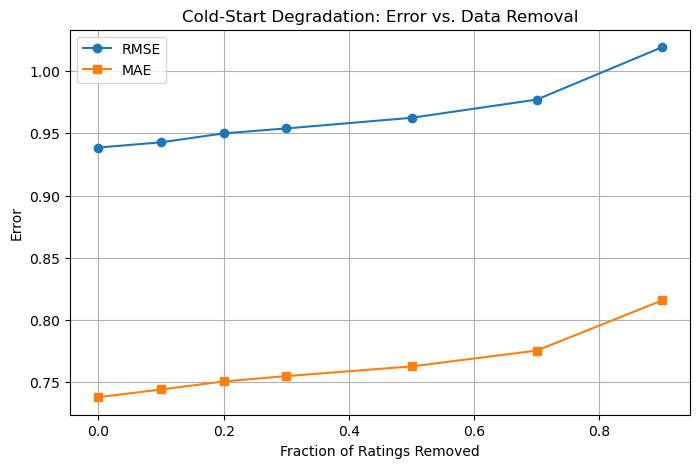

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fractions_kept, rmses, maes = zip(*results)
fractions_removed = [1 - f for f in fractions_kept]  # fraction removed

fig = plt.figure(figsize=(8, 5))
plt.plot(fractions_removed, rmses, label='RMSE', marker='o')
plt.plot(fractions_removed, maes, label='MAE', marker='s')
plt.xlabel("Fraction of Ratings Removed")
plt.ylabel("Error")
plt.title("Cold-Start Degradation: Error vs. Data Removal")
plt.grid(True)
plt.legend()
fig

# Get users with 10-20 ratings

In [33]:
low_activity_users = ratings['user_id'].value_counts()
low_activity_user_ids = low_activity_users[(low_activity_users >= 20) & (low_activity_users <= 25)].index

low_activity_users = ratings[ratings['user_id'].isin(low_activity_user_ids)]
print(f"Total ratings: {len(low_activity_users)}")


Total ratings: 3037


# Train SVD on low activity users

In [56]:
reader = Reader(rating_scale=(1, 5))

train_df_low = low_activity_users[
    ~low_activity_users.apply(lambda row: (row['user_id'], row['movie_id']) in test_pairs, axis=1)
]

data_low = Dataset.load_from_df(train_df_low[['user_id', 'movie_id', 'rating']], reader)
trainset_low = data_low.build_full_trainset()

algo_low = SVD()
algo_low.fit(trainset_low)

predictions_low = algo_low.test(testset_global)

rmse_low = accuracy.rmse(predictions_low)
mae_low = accuracy.mae(predictions_low)

print(f"[Low-Activity Users] RMSE: {rmse_low:.4f}, MAE: {mae_low:.4f}")

RMSE: 1.1007
MAE:  0.9128
[Low-Activity Users] RMSE: 1.1007, MAE: 0.9128


# Take the users from the user database

In [44]:
user_df = pd.read_csv(f"{DATA_DIR}u.user", sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])

low_user_profiles = user_df[user_df['user_id'].isin(low_activity_user_ids)]

low_user_profiles = low_user_profiles.sample(n=10, random_state=42)
print(f"Retrieved {len(low_user_profiles)} low-activity user profiles.")

Retrieved 10 low-activity user profiles.


# Take movies with a lot of ratings

In [45]:
items = pd.read_csv(f'{DATA_DIR}u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

temp = ratings.groupby('movie_id').size()

frequent_item_ids = temp[temp > 200].index

movies_with_many_ratings = items[items['movie_id'].isin(frequent_item_ids)]

movies_with_many_ratings['title'] = movies_with_many_ratings['title'].str.replace('|', ';')

titles_string = '; '.join(movies_with_many_ratings['title'].tolist())

print(titles_string)

Toy Story (1995); Get Shorty (1995); Twelve Monkeys (1995); Babe (1995); Dead Man Walking (1995); Seven (Se7en) (1995); Usual Suspects, The (1995); Mr. Holland's Opus (1995); Braveheart (1995); Birdcage, The (1996); Apollo 13 (1995); Star Wars (1977); Pulp Fiction (1994); Shawshank Redemption, The (1994); Forrest Gump (1994); Four Weddings and a Funeral (1994); Lion King, The (1994); Fugitive, The (1993); Jurassic Park (1993); Sleepless in Seattle (1993); Blade Runner (1982); Aladdin (1992); Terminator 2: Judgment Day (1991); Dances with Wolves (1990); Silence of the Lambs, The (1991); Fargo (1996); Truth About Cats & Dogs, The (1996); Rock, The (1996); Twister (1996); Independence Day (ID4) (1996); Phenomenon (1996); Godfather, The (1972); Wizard of Oz, The (1939); 2001: A Space Odyssey (1968); Sound of Music, The (1965); Die Hard (1988); Willy Wonka and the Chocolate Factory (1971); Fish Called Wanda, A (1988); Top Gun (1986); Monty Python and the Holy Grail (1974); Empire Strikes Ba

C:\Users\User\AppData\Local\Temp\ipykernel_17620\3940061407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_many_ratings['title'] = movies_with_many_ratings['title'].str.replace('|', ';')


# Prompt

In [66]:
prompt = f"""
You are a movie recommendation assistant tasked with simulating user ratings in a recommendation system. I will provide:

1. A list of movie titles.
2. A list of user profiles, each with the following attributes: age, gender, occupation, and zip code. It will also include a user ID you should use only for identification purposes.

For each user, select 30 movies from the list that you believe match their preferences, based on their profile. The selection should reflect a reasonable balance of relevance and diversity (not overly narrow, but not random either).

For each selected movie, assign a realistic rating from 1 to 5:
- 1 = strongly disliked
- 5 = strongly liked

Return the results in **JSON format** using the structure below:

[
  {{
    "user_id": ...,
    "recommendations": [
      {{"title": "...", "rating": ...}},
      ...
    ]
  }},
  ...
]

The movie titles are as follows:
{titles_string}

The user profiles are as follows:
{low_user_profiles}

"""

# Generate LLM recommendations

In [67]:
from google import genai
#
client = genai.Client(api_key="key")

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt,
)

print(response.text)

```json
[
  {
    "user_id": 725,
    "recommendations": [
      {"title": "Toy Story (1995)", "rating": 5},
      {"title": "Get Shorty (1995)", "rating": 4},
      {"title": "Twelve Monkeys (1995)", "rating": 3},
      {"title": "Usual Suspects, The (1995)", "rating": 5},
      {"title": "Apollo 13 (1995)", "rating": 4},
      {"title": "Star Wars (1977)", "rating": 5},
      {"title": "Pulp Fiction (1994)", "rating": 5},
      {"title": "Forrest Gump (1994)", "rating": 4},
      {"title": "Jurassic Park (1993)", "rating": 4},
      {"title": "Terminator 2: Judgment Day (1991)", "rating": 5},
      {"title": "Fargo (1996)", "rating": 4},
      {"title": "Rock, The (1996)", "rating": 4},
      {"title": "Independence Day (ID4) (1996)", "rating": 4},
      {"title": "Die Hard (1988)", "rating": 5},
      {"title": "Top Gun (1986)", "rating": 3},
      {"title": "Raiders of the Lost Ark (1981)", "rating": 5},
      {"title": "Aliens (1986)", "rating": 4},
      {"title": "Return of the 

In [68]:
text_response = response.text
print(len(text_response))


17381


In [69]:
import json
import pandas as pd

item_title_to_id = dict(zip(items['title'], items['movie_id']))

cleaned = text_response.strip()
if cleaned.startswith("```json"):
    cleaned = cleaned[7:]
if cleaned.startswith("```"):
    cleaned = cleaned[3:]
if cleaned.endswith("```"):
    cleaned = cleaned[:-3]
cleaned = cleaned.strip()

parsed = json.loads(cleaned)

ratings_data = []
for user in parsed:
    user_id = user["user_id"]
    for rec in user["recommendations"]:
        ratings_data.append({
            "user_id": user_id,
            "movie_id": item_title_to_id.get(rec["title"], None),  # Use title to get item_id
            "rating": rec["rating"]
        })

ratings_df = pd.DataFrame(ratings_data)

ratings_df

,user_id,movie_id,rating
0,725,1,5
1,725,4,4
2,725,7,3
3,725,12,5
4,725,28,4
...,...,...,...
295,571,234,4
296,571,257,4
297,571,302,5
298,571,333,4


# Combine ratings with original ratings

In [70]:
ratings_df_clean = ratings_df.dropna(subset=['movie_id'])

ratings_df_clean['movie_id'] = ratings_df_clean['movie_id'].astype(int)

# Combine original + synthetic ratings
combined_ratings = pd.concat([low_activity_users[['user_id', 'movie_id', 'rating']], ratings_df_clean], ignore_index=True)

print(f"Original ratings: {len(low_activity_users)}")
print(f"Synthetic ratings: {len(ratings_df_clean)}")
print(f"Combined total: {len(combined_ratings)}")

combined_ratings.head()

Original ratings: 3037
Synthetic ratings: 300
Combined total: 3337


,user_id,movie_id,rating
0,166,346,1
1,50,246,3
2,278,603,5
3,242,1137,5
4,260,322,4


# Train SVD on combined ratings

In [78]:
reader = Reader(rating_scale=(1, 5))

train_df_combined = combined_ratings[
    ~combined_ratings.apply(lambda row: (row['user_id'], row['movie_id']) in test_pairs, axis=1)
]

data_combined = Dataset.load_from_df(train_df_combined[['user_id', 'movie_id', 'rating']], reader)
trainset_combined = data_combined.build_full_trainset()

algo_combined = SVD()
algo_combined.fit(trainset_combined)

# Evaluate on global testset
predictions_combined = algo_combined.test(testset_global)

rmse_combined = accuracy.rmse(predictions_combined)
mae_combined = accuracy.mae(predictions_combined)

print(f"[Low-Activity Users + LLM] RMSE: {rmse_combined:.4f}, MAE: {mae_combined:.4f}")

RMSE: 1.0978
MAE:  0.8970
[Low-Activity Users + LLM] RMSE: 1.0978, MAE: 0.8970
